In [1]:
import os, sys
import numpy as np
import pandas as pd
from scipy import signal
import matplotlib.pyplot as plt
import IPython.display as ipd
import librosa.display
import soundfile as sf
from scipy.ndimage import filters
sys.path.append('..')

import LibFMP
import LibFMP.B
import LibFMP.C5
import LibFMP.C6
import LibFMP.C8

%matplotlib inline

chords_moll = ["Cm", "C#m", "Dm", "D#m", "Em", "Fm", "F#m", "Gm", "G#m", "Am", "A#m", "Bm"]
chords_dur =  ["C", "C#", "D", "D#", "E", "F", "F#", "G", "G#", "A", "A#", "B"]

In [2]:
def compute_chromagram(x, Fs=22050, N=4096, H=2048, gamma=None, version='STFT', norm='2'):
    """Compute chromagram for WAV file specified by filename

    Notebook: C5/C5S2_ChordRec_Templates.ipynb

    Args:
        fn_wav: Filenname of WAV
        Fs: Sampling rate
        N: Window size
        H: Hop size
        gamma: Constant for logarithmic compression
        version: Technique used for front-end decomposition ('STFT', 'IIS', 'CQT')
        norm: If not 'None', chroma vectors are normalized by norm as specified ('1', '2', 'max')

    Returns:
        X: Chromagram
        Fs_X: Feature reate of chromagram
        x: Audio signal
        Fs: Sampling rate of audio signal
        x_dur: Duration (seconds) of audio signal
    """
    x_dur = x.shape[0] / Fs
    if version == 'STFT':
        # Compute chroma features with STFT
        X = librosa.stft(x, n_fft=N, hop_length=H, pad_mode='constant', center=True)
        if gamma is not None:
            X = np.log(1 + gamma * np.abs(X) ** 2)
        else:
            X = np.abs(X) ** 2
        X = librosa.feature.chroma_stft(S=X, sr=Fs, tuning=0, norm=None, hop_length=H, n_fft=N)
    if version == 'CQT':
        # Compute chroma features with CQT decomposition
        X = librosa.feature.chroma_cqt(y=x, sr=Fs, hop_length=H, norm=None)
    if version == 'IIR':
        # Compute chroma features with filter bank (using IIR elliptic filter)
        X = librosa.iirt(y=x, sr=Fs, win_length=N, hop_length=H, center=True, tuning=0.0)
        if gamma is not None:
            X = np.log(1.0 + gamma * X)
        X = librosa.feature.chroma_cqt(C=X, bins_per_octave=12, n_octaves=7,
                                       fmin=librosa.midi_to_hz(24), norm=None)
    if norm is not None:
        X = LibFMP.C3.normalize_feature_sequence(X, norm='2')
    Fs_X = Fs / H
    return X, Fs_X, x, Fs, x_dur

def plot_beat_grid(B_sec, ax, color='r', linestyle=':', linewidth=1):
    """Plot beat grid (given in seconds) into axis
    Notebook: C6S3_AdaptiveWindowing.ipynb"""
    for b in B_sec:
        ax.axvline(x=b, color=color, linestyle=linestyle, linewidth=linewidth)

def adaptive_windowing(X, B, neigborhood=1, add_start=False, add_end=False):
    """Apply adaptive windowing [FMP, Section 6.3.3]

    Notebook: C6/C6S3_AdaptiveWindowing.ipynb

    Args:
        X: Feature sequence
        B: Beat sequence (spefied in frames)
        neigborhood: Parameter specifying relative range considered for windowing
        add_start: Add first index of X to beat sequence (if not existent)
        add_end: Add last index of X to beat sequence (if not existent)

    Returns:
        X_adapt: Feature sequence adapted to beat sequence
        B_s, B_t: Sequences specifying start and end (in frames) of window sections
    """
    len_X = X.shape[1]
    max_B = np.max(B)
    if max_B > len_X:
        print('Beat exceeds length of features sequence (b=%d, |X|=%d)' % (max_B, len_X))
        B = B[B < len_X]
    if add_start:
        if B[0] > 0:
            B = np.insert(B, 0, 0)
    if add_end:
        if B[-1] < len_X:
            B = np.append(B, len_X)
    X_adapt = np.zeros((X.shape[0], len(B)-1))
    B_s = np.zeros(len(B)-1).astype(int)
    B_t = np.zeros(len(B)-1).astype(int)
    for b in range(len(B)-1):
        s = B[b]
        t = B[b+1]
        reduce = np.floor((1 - neigborhood)*(t-s+1)/2).astype(int)
        s = s + reduce
        t = t - reduce
        if s == t:
            t = t + 1
        X_slice = X[:, range(s, t)]
        X_adapt[:, b] = np.mean(X_slice, axis=1)
        B_s[b] = s
        B_t[b] = t
    return X_adapt, B_s, B_t

def compute_plot_adaptive_windowing(x, Fs, H, X, B, neigborhood=1, add_start=False, add_end=False):
    """Compute and plot process for adaptive windowing [FMP, Section 6.3.3]
    Notebook: C6/C6S3_AdaptiveWindowing.ipynb"""
    X_adapt, B_s, B_t = adaptive_windowing(X, B, neigborhood=neigborhood,
                                           add_start=add_start, add_end=add_end)

    fig, ax = plt.subplots(2, 2, gridspec_kw={'width_ratios': [1, 0.03],
                                              'height_ratios': [1, 3]}, figsize=(15, 4))

    LibFMP.B.plot_signal(x, Fs, ax=ax[0, 0], title='Adaptive windowing using $\lambda = %0.2f$' % neigborhood)
    ax[0, 1].set_axis_off()
    plot_beat_grid(B_s * H / Fs, ax[0, 0], color='b')
    plot_beat_grid(B_t * H / Fs, ax[0, 0], color='g')
    plot_beat_grid(B * H / Fs, ax[0, 0], color='r')
    for k in range(len(B_s)):
        ax[0, 0].fill_between([B_s[k] * H / Fs, B_t[k] * H / Fs], -1, 1, facecolor='red', alpha=0.1)

    LibFMP.B.plot_matrix(X_adapt, ax=[ax[1, 0], ax[1, 1]], xlabel='Time (frames)', ylabel='Frequency (bins)')
    plt.tight_layout()
    return X_adapt, B_s, B_t


def transform_adaptive_windowed_feature_to_const_fs_feature(X_adapt, B_s, B_t):
    """
    Fs: feature rate of new signal (chromagram feature sequence for chord recognition)
    X_adapt: windowed feature sequence
    B_s, B_t: Sequences specifying start and end (in frames) of window sections
    """    
    X = np.zeros((X_adapt.shape[0], B_t[-1]))
    
    for i in range(X_adapt.shape[1]):
        start_seq = B_s[i]
        end_seq = B_t[i]
        for n in range(start_seq, end_seq):
            X[:, n] = X_adapt[:, i]
    return X    
    

def compute_plot_tempogram_PLP_from_signal(x, Fs=22050, N=500, H=10, N_nov=2048, H_nov=512, Theta=np.arange(30,601),
                               gamma=100, M = 10, norm=1, Fs_out=100, title='', figsize=(8,4), plot_maxtempo=False, 
                               to_overlay_signal=None, beat_start=0, beat_step=1):
    """Compute and plot Fourier-based tempogram and PLP function
    Notebook: C6/C6S3_PredominantLocalPulse.ipynb"""
    nov, Fs_nov = LibFMP.C6.compute_novelty_spectrum(x, Fs=Fs, N=N_nov, H=H_nov, gamma=gamma, M=M, norm=norm)
    nov, Fs_nov = LibFMP.C6.resample_signal(nov, Fs_in=Fs_nov, Fs_out=Fs_out)

    L = len(nov)
    X, T_coef, F_coef_BPM = LibFMP.C6.compute_tempogram_Fourier(nov, Fs=Fs_nov, N=N, H=H, Theta=Theta)
    nov_PLP = LibFMP.C6.compute_PLP(X, Fs_nov, L, N, H, Theta)
    tempogram = np.abs(X)

    fig, ax = plt.subplots(2, 2, gridspec_kw={'width_ratios': [1, 0.05],
                                'height_ratios': [2, 1]}, figsize=figsize)
    LibFMP.B.plot_matrix(tempogram, T_coef=T_coef, F_coef=F_coef_BPM, title=title,
                        ax=[ax[0,0], ax[0,1]], ylabel='Tempo (BPM)', colorbar=True)
    if plot_maxtempo:
        coef_k = np.argmax(tempogram, axis=0)
        ax[0,0].plot(T_coef, F_coef_BPM[coef_k], 'r.')

    t_nov = np.arange(nov.shape[0]) / Fs_nov
    peaks, properties = signal.find_peaks(nov_PLP, prominence=0.05)
    peaks = peaks[beat_start::beat_step]
    peaks_sec = t_nov[peaks]
    LibFMP.B.plot_signal(nov_PLP, Fs_nov, color='k', ax=ax[1,0]);
    ax[1,1].set_axis_off()
    ax[1,0].plot(peaks_sec, nov_PLP[peaks], 'ro')
    plt.show()
    x_peaks = librosa.clicks(peaks_sec, sr=Fs, click_freq=1000, length=len(x))
    return nov_PLP, Fs_nov, peaks

def chord_recognition(X, p=0.15, filt_len=None, filt_type='mean', transition_matrix='uniform'):
    """Conduct template- and HMM-based chord recognition and evaluates the approaches

    Notebook: C5//C5/C5S3_ChordRec_Beatles.ipynb

    Args:
        X: Chromagram
        p: Self-transition probability used for HMM
        filt_len: Filter length used for prefilitering
        filt_type ('mean', 'meadian'): Filter type used for prefilitering

    Returns:
        result_Tem, result_HMM: Chord recogntion evaluation results [P, R, F, TP, FP, FN]
                                for template- and HMM-based approach
        chord_Tem: Template-based chord recogntion result given as binary matrix
        chord_HMM: HMM-based chord recogntion result given as binary matrix
        chord_sim: Chord similarity matrix
    """
    if filt_len is not None:
        if filt_type == 'mean':
            X, Fs_X = LibFMP.C3.smooth_downsample_feature_sequence(X, Fs=1, filt_len=filt_len, down_sampling=1)
        if filt_type == 'median':
            X, Fs_X = LibFMP.C3.median_downsample_feature_sequence(X, Fs=1, filt_len=filt_len, down_sampling=1)
    # Template-based chord recogntion
    chord_sim, chord_Tem = LibFMP.C5.chord_recognition_template(X, norm_sim='1')
    # HMM-based chord recogntion
    if transition_matrix == 'uniform':
        A = LibFMP.C5.uniform_transition_matrix(p=p)
    elif transition_matrix == 'invariant':
        fn_csv = os.path.join('data', 'C5', 'FMP_C5_transitionMatrix_Beatles.csv')
        A_est_df = pd.read_csv(fn_csv, delimiter=';')
        A_est = A_est_df.to_numpy('float64')
        A = LibFMP.C5.matrix_chord24_trans_inv(A_est)
    plt.figure()
    plt.imshow(A)
    C = 1 / 24 * np.ones((1, 24))
    B_O = chord_sim
    chord_HMM, _, _, _ = LibFMP.C5.viterbi_log_likelihood(A, C, B_O)
    return chord_Tem, chord_HMM, chord_sim

In [3]:
def do_chord_recognition(window, x, Fs, use_HPS=True, use_PLP_beat_track=True, Theta=np.arange(50,300), start_bpm=120, transition_matrix='invariant', neigborhood=1, p=0.15):
    # do HPS
    if use_HPS:
        L_h = 30
        L_p = 50
        N_hps = 1024
        H_hps = 256
        x_h, x_p = LibFMP.C8.HPS(x, Fs, N_hps, H_hps, L_h, L_p, L_unit='indices', mask='binary', eps=0.001, detail=False)
    else:
        x_h = x
        x_p = x
    
    print('HPS done')
    window.incrementProgress()
    
        
    # compute Novelty and Pulse
    N_nov = 2048
    H_nov = 512
    gamma_nov = 1000
    #use_PLP_beat_track = False

    if use_PLP_beat_track:
        # PLP params
        N = 10000
        H = 10
        M = 10
        norm = 1
        Fs_out = 100

        # in compute_plot_tempogram_PLP_from_signal also the peak picking strategy is implemented
        nov_PLP, Fs_nov, peaks = compute_plot_tempogram_PLP_from_signal(x_p, Fs=Fs, N=N, H=H, N_nov=N_nov, H_nov=H_nov, Theta=Theta, 
                                                                gamma=gamma_nov, M=M, norm=norm, Fs_out=Fs_out, title='Tempogram', 
                                                                figsize=(8,4), plot_maxtempo=True, to_overlay_signal=x,
                                                                beat_start=0, beat_step=1)

        fig, ax, line = LibFMP.B.plot_signal(nov_PLP, Fs_nov, color='k', 
                            title='Spectral-based novelty function with normalization');

        B_adapt_sec = peaks/Fs_nov
    else:
        # librosa beat tracking
        tempo, beats = librosa.beat.beat_track(y=x_p, sr=Fs, start_bpm=start_bpm)
        beats_sec = librosa.frames_to_time(beats, sr=Fs)
        x_peaks = librosa.clicks(beats_sec, sr=Fs, click_freq=1000, length=len(x))
        B_adapt_sec = beats_sec
        
    print('Beat tracking done')
    window.incrementProgress()

    B_adapt_frame = np.round(B_adapt_sec*Fs/H_nov).astype(int)

    N_chroma = N_nov
    H_chroma = H_nov
    gamma_chroma = gamma_nov
    X_h, Fs_X, x_h, Fs, x_dur = compute_chromagram(x_h, Fs=Fs, N=N_chroma, H=H_chroma, gamma=gamma_chroma, version='CQT', norm='2')
    Chromagram = X_h

    add_start = True
    add_end = True
    Chromagram_adapt, B_s, B_t = compute_plot_adaptive_windowing(x, Fs, H_chroma, Chromagram, B_adapt_frame, 
                            neigborhood=neigborhood, add_start=add_start, add_end=add_end)
    backtransformed_Chromagram = transform_adaptive_windowed_feature_to_const_fs_feature(Chromagram_adapt, B_s, B_t)


    # adapted frames Chord Recognition
    N_X = backtransformed_Chromagram.shape[1]
    
    print('Transforming done')
    window.incrementProgress()

    chord_Tem, chord_HMM, chord_sim = chord_recognition(backtransformed_Chromagram, p=p, filt_len=3, transition_matrix=transition_matrix)
    print('Chord recognition done')
    window.incrementProgress()
    
    return chord_Tem, chord_HMM, chord_sim, backtransformed_Chromagram
 

In [4]:
def get_basis_for_animation(x, Fs, chord_HMM, backtransformed_Chromagram, interval=100.):
    N_X = backtransformed_Chromagram.shape[1]
    fps = N_X / (len(x) / Fs) 
    # change chord recognition result into annotation 
    chords = chords_dur + chords_moll
    diff_chord = np.diff(chord_HMM[0])
    ann_seg_ind_result = []
    diff_chords = np.diff(chord_HMM)

    for k in range(chord_HMM.shape[0]):
        start_indices = list(np.where(diff_chords[k] == 1)[0] + 1)
        end_indices = list(np.where(diff_chords[k] == -1)[0] + 1)
        if len(start_indices) != 0 or len(end_indices) != 0:
            if (len(start_indices) != 0 and len(end_indices) != 0 and end_indices[0] < start_indices[0]) \
                or (len(start_indices) == 0 and len(end_indices) == 1):
                # first index is missing
                start_indices.insert(0, 0)
            if len(start_indices) != len(end_indices):
                # last index is missing
                end_indices.append(N_X)

            assert len(start_indices) == len(end_indices)
            ann_seg_ind_result.extend(list(zip(start_indices, end_indices, [chords[k]] * len(start_indices))))


    color_ann = {'C': [1, 0.5, 0, 1], 'G': [0, 1, 0, 1], 'Am': [1, 0, 0, 1], 'D': [1, 1, 1, 1]}
    cmap = plt.get_cmap("tab20")
    chords_colors = dict()
    for i in range(20):
        rgba = np.array(cmap(i))
        ch = chords_moll[i//2] if i % 2 == 1 else chords_dur[i//2]     
        chords_colors[ch] = rgba

    chords_colors["A#"] = [0.96, 0.88, 0, 1]
    chords_colors["B"] = [0, 0.83, 0.46, 1]
    chords_colors["A#m"] = [0.95, 0.92, 0.62, 1]
    chords_colors["Bm"] = [0.72, 0.90, 0.84, 1]
    # number of frames per second
    fps = N_X / (len(x) / Fs)

    # transfer from frames in seconds
    ann_seg_ind_sec = []
    for start, stop, chord in ann_seg_ind_result:
        ann_seg_ind_sec.append([start/fps, stop/fps, chord])
 
    # length covered in 1s : (1/interval) * updateX
    frames = int((len(x) / Fs)*(1000./interval))
    print('Get basis for animation done')
    return ann_seg_ind_sec, chords_colors



pygame 2.0.1 (SDL 2.0.14, Python 3.7.9)
Hello from the pygame community. https://www.pygame.org/contribute.html
buttonOkClick


C:\Users\stefa\anaconda3\envs\FMP\lib\site-packages\librosa\core\audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


HPS done


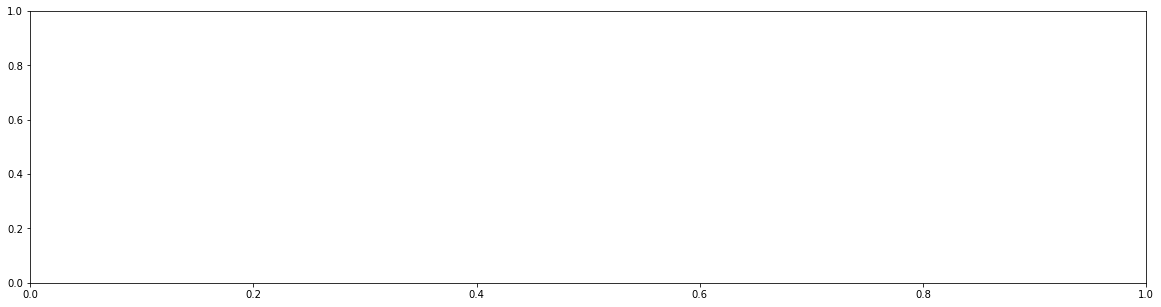

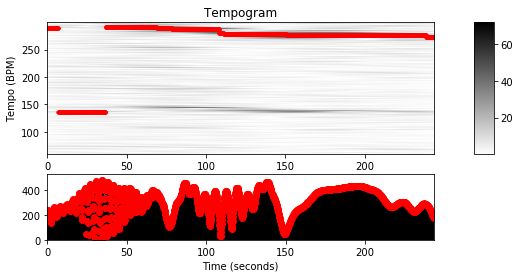

Beat tracking done
Transforming done
Chord recognition done
Get basis for animation done


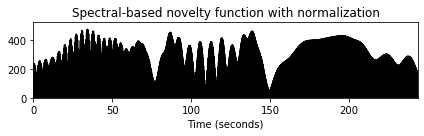

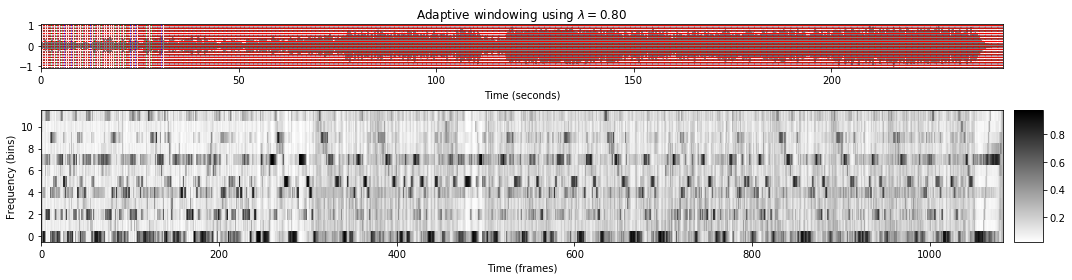

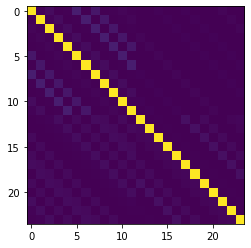

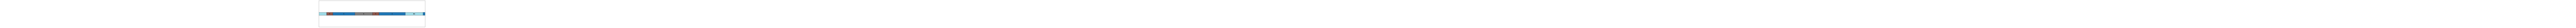

In [5]:
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import tkinter as tk
from tkinter import *
from tkinter import filedialog
import pygame
import pylab
import os
import IPython.display as ipd
from pygame import mixer
import tkinter.messagebox as tmb
import matplotlib.animation as animation
import time
from tkinter import ttk
import numpy as np

class Window(Frame):
    def __init__(self, master = None):
        Frame.__init__(self, master)
        self.master = master
        self.init_window()
        #self.detailWindow = detailWindow

    def init_window(self):
        #setup
        self.master.title("Music Player")
        self.pack(fill='both', expand=1)     
        pygame.init()
        pygame.mixer.init()
        
        #for closing
        self.master.wm_protocol('WM_DELETE_WINDOW', self.close_app)        
        self.track = StringVar()
        self.status = StringVar()

        #songlabel, status
        trackframe = LabelFrame(self,text="Song Track",font=("times new roman",15,"bold"),
                                bg="grey",fg="lightgrey",bd=5,relief=GROOVE)
        trackframe.place(x=0,y=570,width=1500,height=140)
        songtrack = Label(trackframe,textvariable=self.track,width=20,font=("times new roman",15,"bold"),
                          bg="grey",fg="white").grid(row=3,column=3,padx=20,pady=0)
        trackstatus = Label(trackframe,textvariable=self.status,font=("times new roman",15,"bold"),
                            bg="grey",fg="white").grid(row=3,column=20,padx=10,pady=0)
        playbtn = Button(trackframe,text="LOAD",command=self.load,width=8,height=1,font=("times new roman",14,"bold"),
                         fg="black",bg="lightgrey").grid(row=0,column=1,padx=10,pady= 0)
        
        #Buttons for control panel
        buttonframe = LabelFrame(self,text="Control Panel",font=("times new roman",15,"bold"),bg="grey",fg="lightgrey",
                                 bd=5,relief=GROOVE)
        buttonframe.place(x=0,y=430,width=750,height=140)
        
        pausephoto = PhotoImage(file = os.path.join('..','projekt', 'data','pause.png')) 
        pausebtn = Button(buttonframe, image=pausephoto,command=self.pause,width=80,height=50,compound = LEFT)
        pausebtn.image = pausephoto
        pausebtn.grid(row=3,column=3,padx=10,pady=10)

        playphoto = PhotoImage(file = os.path.join('..','projekt', 'data','play.png')) 
        playbtn = Button(buttonframe, image=playphoto,command=self.play,width=80,height=50,compound = LEFT)
        playbtn.image = playphoto
        playbtn.grid(row=3,column=2,padx=10,pady=10)

        tostartphoto = PhotoImage(file = os.path.join('..','projekt', 'data','to_start.png')) 
        tostartbtn = Button(buttonframe, image=tostartphoto,command=self.to_start,width=80,height=50,compound = LEFT)
        tostartbtn.image = tostartphoto
        tostartbtn.grid(row=3,column=1,padx=10,pady=5)
                
        stopphoto = PhotoImage(file = os.path.join('..','projekt', 'data','stop.png')) 
        stopbtn = Button(buttonframe, image=stopphoto,command=self.stop,width=80,height=50,compound = LEFT)
        stopbtn.image = stopphoto
        stopbtn.grid(row=3,column=4,padx=10,pady=5)
        
        #for playback
        playbackframe = LabelFrame(self,text="Playback",font=("times new roman",15,"bold"),bg="grey",fg="lightgrey",
                                   bd=5,relief=GROOVE)
        playbackframe.place(x=750,y=430,width=750,height=140)
        chordsbtn = Button(playbackframe,text="CHORDS",command=self.chords,width=10,height=2,font=("times new roman",14,"bold"),
                           fg="black",bg="white").grid(row=3,column=0,padx=10,pady=5)

        transpose_minus_photo = PhotoImage(file = os.path.join('..','projekt', 'data','transpose_minus.png')) 
        transpose_minus_btn = Button(playbackframe, image=transpose_minus_photo,command=self.transpose_minus,width=100,
                                     height=56,compound = LEFT)
        transpose_minus_btn.image = transpose_minus_photo
        transpose_minus_btn.grid(row=3,column=1,padx=10,pady=5)  

        transpose_plus_photo = PhotoImage(file = os.path.join('..','projekt', 'data','transpose_plus.png')) 
        transpose_plus_btn = Button(playbackframe, image=transpose_plus_photo,command=self.transpose_plus,width=100,
                                    height=56,compound = LEFT)
        transpose_plus_btn.image = transpose_plus_photo
        transpose_plus_btn.grid(row=3,column=2,padx=10,pady=5)  
        
        self.transposeString = StringVar()
        transposestatus = Label(playbackframe,textvariable=self.transposeString,font=("times new roman",15,"bold"),
                            bg="grey",fg="white").grid(row=3,column=20,padx=10,pady=0)
                
        #for transpose fct
        self.transposeInt=0
        self.transposeString.set("Transpose Level: " + str(self.transposeInt))
        #for progress bar
        self.progress_var = 0
        self.progressbarWindow = None
        self.progressbar = None
        self.progress_var_MAX = 4 # all steps starting from 0: HPS, beat tracking, transform, chord rec, get animation basis 
        
        #playback
        chordframe = LabelFrame(self,text="Playback",font=("times new roman",15,"bold"),bg="grey",fg="lightgrey",
                                bd=5,relief=GROOVE)
        chordframe.place(x=0,y=0,width=1500,height=430)
        
        self.music_file = False
        self.playing_state = False
        self.chords_loaded = False
        self.paused = False
        self.stopped = False
        self.chord_recognition_to_do = False
        self.ani = None
        self.interval = 30.
        self.frames = None
        self.updateX = None
 
        
    def load_playback(self):        
        tk.Label(self,text="Chords").grid(column=0, row=7)
        self.fig, self.ax = plt.subplots(figsize=(20,5))
        
        # ----------------- DO CHORD RECOGNITION -----------------
        if self.chord_recognition_to_do:
            # Create and draw Progress-Bar
            self.progress_var = 0
            self.progressbarWindow = tk.Tk()
            self.progressbarWindow.geometry('320x120')
            theLabel = tk.Label(self.progressbarWindow, text="Progress of Chord Recognition")
            theLabel.pack()
            self.progressbar = ttk.Progressbar(self.progressbarWindow, mode="determinate",
                         orient=tk.HORIZONTAL, maximum=self.progress_var_MAX)
            self.progressbar.pack()
            self.progressbar.update()
                   
            self.x, self.Fs = librosa.load(self.music_file, 44100)
            chord_Tem, chord_HMM, chord_sim, \
            backtransformed_Chromagram = do_chord_recognition(self, self.x, 
                                                            self.Fs, use_HPS=self.detail_window.HPS, 
                                                            use_PLP_beat_track=self.detail_window.PLP,
                                                            start_bpm=self.detail_window.start_bpm, 
                                                            Theta=self.detail_window.theta, neigborhood=0.8, 
                                                            transition_matrix=self.detail_window.tm)
            self.ann_seg_ind_sec, self.chords_colors = get_basis_for_animation(self.x, self.Fs, chord_HMM, 
                                                                               backtransformed_Chromagram, self.interval)
            self.chord_recognition_to_do = False
        # --------------- END DO CHORD RECOGNITION ---------------
        
        #allChords = ["C", "Cm", "C#", "C#m","D", "Dm","D#", "D#m","E", "Em","F", "Fm","F#", "F#m","G", "Gm","G#", "G#m", "A", "Am","A#", "A#m","B", "Bm"]
        allChords = [None] * 24
        allChords[::2] = chords_dur
        allChords[1::2] = chords_moll
        
        ann_seg_ind_sec = self.ann_seg_ind_sec.copy()
        
        for i in range(len(ann_seg_ind_sec)):
            seg = ann_seg_ind_sec[i]
            chord = seg[2]
            idx = allChords.index(chord)
            # transpose*2 to jump from major to major
            if idx + 2*self.transposeInt >= len(allChords):
                overflow = (idx + 2*self.transposeInt - len(allChords)) % 24
                newChord = allChords[overflow]
            else:
                newChord = allChords[idx+self.transposeInt*2]
            ann_seg_ind_sec[i] = [seg[0], seg[1], newChord]
        
        
        self.x = LibFMP.B.plot_segments(ann_seg_ind_sec, ax=self.ax, time_axis=None, time_max=(len(self.x) / self.Fs),
                                colors=self.chords_colors, alpha=1)
        
        self.ax.set_xlim(0, 10)
        self.ax.set_ylim(-4, 5)   
        self.canvas = FigureCanvasTkAgg(self.fig, master=self)
        self.canvas.get_tk_widget().grid(column=0,row=300, padx = 30, pady=20)
        if self.ani is not None:
            self.ani.event_source.stop()
    
    def animate(self,i):
        mt = mixer.music.get_pos()
        self.ax.set_xlim(mt/1000, mt/1000+10)
        return

    def load(self):
        self.music_file = filedialog.askopenfilename(filetypes=[("Audio files",(".wav", ".mp3"))])
        self.track.set(os.path.basename(self.music_file))
        if self.chords_loaded:
            self.status.set("-Loaded, Please refresh chords aswell!")
        else:
            self.status.set("-Loaded")
        if self.ani is not None:
            self.ani.event_source.stop()
        self.chord_recognition_to_do = True
        
        
    def to_start(self):
        if self.music_file:
            self.status.set("-Reset")
            if self.chords_loaded:
                self.load_playback()
                self.ani = animation.FuncAnimation(self.fig, self.animate, interval=self.interval)
                self.chords_loaded = True
                self.ani.event_source.start()
            mixer.init()
            self.start_anim = True
            self.playing_state = True
            self.stopped = False
            mixer.music.load(self.music_file)
            self.track.set(os.path.basename(self.music_file))
            self.status.set("-Playing")
            mixer.music.play() 
            
    def play(self):
        if self.music_file:
            if not self.playing_state:
                if self.paused:
                    if self.chords_loaded:
                        self.ani.event_source.start()
                    mixer.music.unpause()
                else:#if self.stopped or at first start
                    self.to_start() 
                
        self.paused = False
        self.playing_state=True
        self.stopped = False
        self.status.set("-Playing")
        
    def pause(self):
        #self.ani.event_source.stop()
        if self.music_file and not self.stopped:
            if self.playing_state:
                if self.chords_loaded:
                    self.ani.event_source.stop()
                mixer.music.pause()
                self.paused = True
                self.status.set("-Paused")
                self.playing_state = False  
                self.stopped = False                
                
    def stop(self):
        if self.music_file:
            self.playing_state = False
            self.paused = False
            if self.ani is not None:
                self.ani.event_source.stop()
            mixer.music.stop()
            self.stopped = True
            self.status.set("-Stopped")
            if self.ani is not None:
                self.ani.event_source.stop()
            
    def incrementProgress(self):
        self.progress_var = self.progress_var+1
        self.progressbar["value"] = self.progress_var
        self.progressbar.update()
        if self.progress_var == self.progress_var_MAX:
            self.progressbarWindow.destroy()
        return
        
    def chords(self, transpose=0):
        #for animation
        if not self.music_file :
            self.status.set("-Select song first!")
        else: 
            self.status.set("-Wait for Chord Recognition")
        self.create_detail_window()
        
    def create_detail_window(self):
        self.newDetailsWindow=tk.Toplevel(self.master)
        self.newDetailsWindow.geometry('900x600+80+130')
        self.newDetailsWindow.wm_protocol("WM_DELETE_WINDOW", self.newDetailsWindow.destroy)
        self.detail_window = detailWindow(self.newDetailsWindow, self)
        self.newDetailsWindow.focus()
        
    def buttonOkClick(self):
        mixer.init()
        mixer.music.load(self.music_file)
        self.transposeInt = 0             
        self.load_playback()
        self.stop()
        self.chords_loaded = True
        self.status.set("-Chord recognition done")
        self.transposeString.set("Transpose Level: " + str(self.transposeInt))
        
    def transpose_plus(self):
        self.transposeInt += 1
        if self.transposeInt == 12:
            self.transposeInt = 0
        print(self.transposeInt)
        self.load_playback()
        self.stop()
        self.transposeString.set("Transpose Level: " + str(self.transposeInt))
        
    def transpose_minus(self):
        self.transposeInt -= 1 
        if self.transposeInt == -1:
            self.transposeInt = 11
        print(self.transposeInt)
        self.load_playback()
        self.stop()
        self.transposeString.set("Transpose Level: " + str(self.transposeInt))
    
        
    def close_app(self):
        if tmb.askokcancel("Close", "Are you sure...?"):
            mixer.music.stop()
            self.master.destroy()
            
#second class for Parameter Window for chord recognition        
class detailWindow(Frame):
    """ Base class for secondary windows """
    def __init__(self, master, window):
        Frame.__init__(self, master)
        self.master = master
        self.window = window
        self.master.minsize(900, 600)
        self.master.maxsize(900, 600)
        self.mainframe = ttk.Frame(master)
        self.mainframe.pack()
        self.HPS = None
        self.PLP = None
        self.start_bpm = None
        self.theta = None
        self.tm =  None
        self.Fs = None
        
        self.lbl_text = ttk.Label(master,
                                  text="Parameters for chord recognition")
        self.lbl_text.pack()
        buttonok = Button(master, bg='#FBD975', text='ok', command=self.buttonOkClick)
        buttonok.place(x=54, y=400, width=100, height=27)
        
        
        labelHPS = Label(master, text='Use HPS (True/False)', compound=LEFT)
        labelHPS.place(x=0, y=24, width=480, height=27)
        hps = StringVar(root, value='False')
        self.entryHPS = Entry(master, bg='white', textvariable = hps)
        self.entryHPS.place(x=500, y=24, width=100, height=27)

        labelPLP = Label(master, text='Use PLP for beat tracking (True/False), if False: librosa beat tracking is used', compound = LEFT)
        labelPLP.place(x=0, y=52, width=480, height=27)
        plp = StringVar(root, value='True')
        self.entryPLP = Entry(master, bg='white', textvariable=plp)
        self.entryPLP.place(x=500, y=52, width=100, height=27)
        
        labelstart_bpm = Label(master, text='start_BPM if librosa beat tracking is used', compound=LEFT)
        labelstart_bpm.place(x=0, y=79, width=480, height=27)
        start_bpm = StringVar(root, value='120')
        self.entrystart_bpm = Entry(master, bg='white', textvariable=start_bpm)
        self.entrystart_bpm.place(x=500, y=79, width=100, height=27)
        
        labeltheta = Label(master, text='Define Theta (range of beats per minute) for PLP', compound=LEFT)
        labeltheta.place(x=0, y=107, width=480, height=27)
        theta1 = StringVar(root, value='60')
        self.entrytheta1 = Entry(master, bg='white', textvariable=theta1)
        self.entrytheta1.place(x=500, y=107, width=50, height=27)
                
        labeltheta2 = Label(master, text=' - ', compound=LEFT)
        labeltheta2.place(x=530, y=107, width=20, height=27)
        
        theta2 = StringVar(root, value='300')
        self.entrytheta2 = Entry(master, bg='white', textvariable=theta2)
        self.entrytheta2.place(x=550, y=107, width=50, height=27)
        
        labeltm = Label(master, text='Transition Matrix for HMM (uniform/invariant)', compound=LEFT)
        labeltm.place(x=0, y=135, width=480, height=27)
        tm = StringVar(root, value='invariant')
        self.entrytm = Entry(master, bg='white', textvariable=tm)
        self.entrytm.place(x=500, y=135, width=100, height=27)
                

    def buttonOkClick(self):
        #get data
        print('buttonOkClick')
        self.HPS = self.entryHPS.get() == "True"
        self.PLP = self.entryPLP.get() == "True"
        self.start_bpm = int(self.entrystart_bpm.get())
        self.theta = np.arange(int(self.entrytheta1.get()), int(self.entrytheta2.get()))
        self.tm = str(self.entrytm.get())
        self.master.destroy()
        self.window.buttonOkClick()

root = tk.Tk()
root.geometry("1500x710")
app = Window(root)
tk.mainloop()